In [42]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")


Done


In [43]:
!apt-get update
!apt-get install -y libsndfile1

Hit:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:2 https://packages.cloud.google.com/apt cloud-sdk InRelease     
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease    
Hit:4 https://packages.cloud.google.com/apt google-fast-socket InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease              
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-7ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.


In [44]:
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"


In [45]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


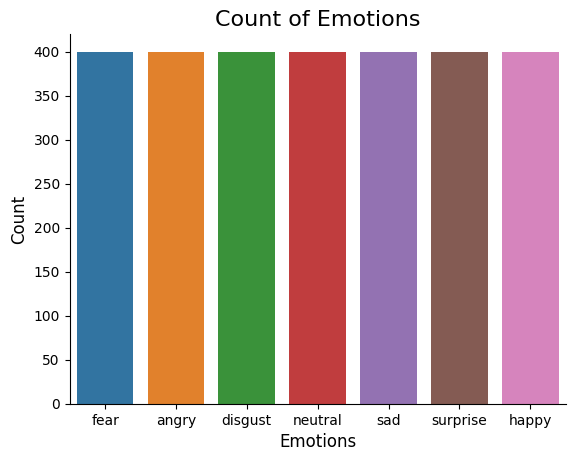

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data=Tess_df, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [47]:
data,sr = librosa.load(file_path[0])
sr

22050

In [48]:
ipd.Audio(data,rate=sr)


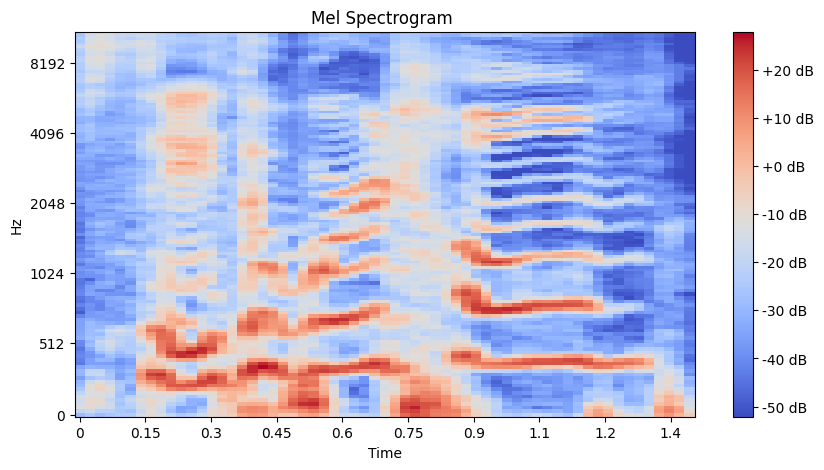

In [49]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB');

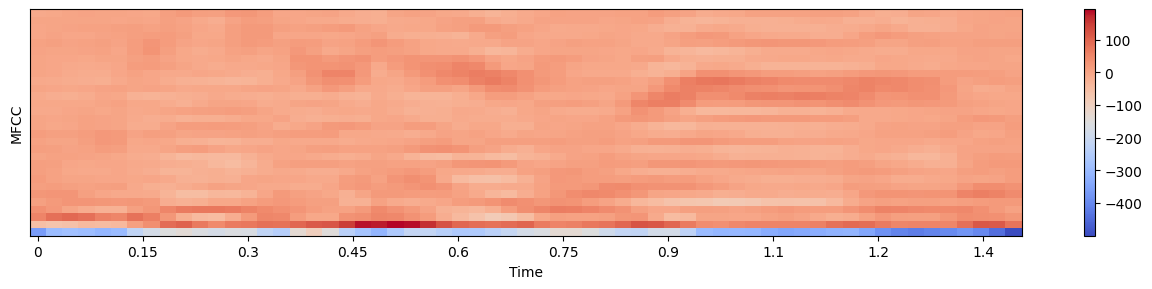

In [50]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

In [61]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

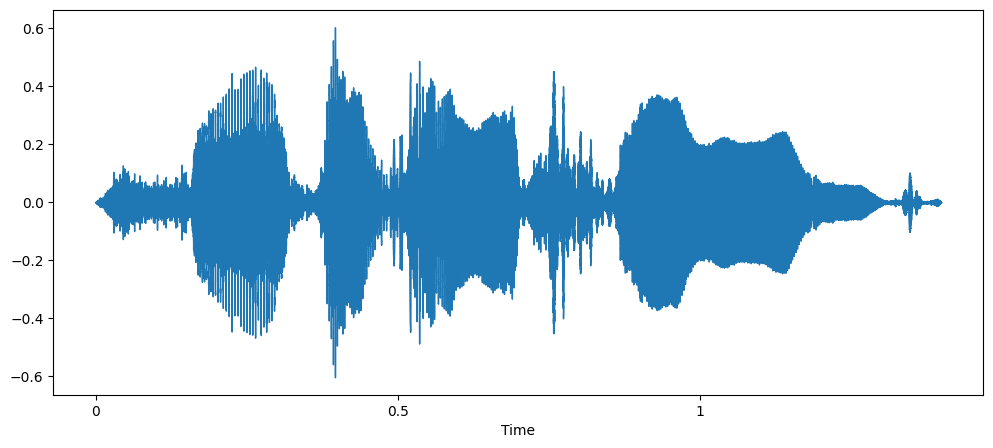

In [62]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
# Save the figure
plt.savefig("NormalAudio.png")
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

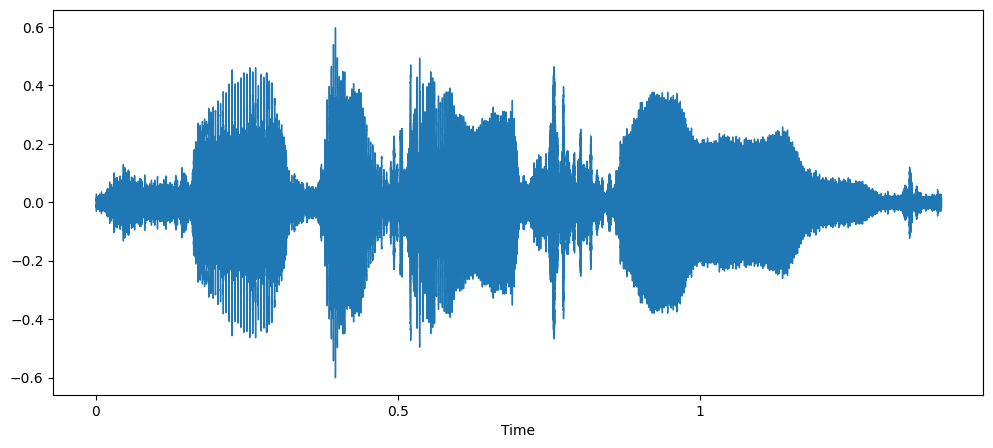

In [63]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
# Save the figure
plt.savefig("NoisedAudio.png")
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

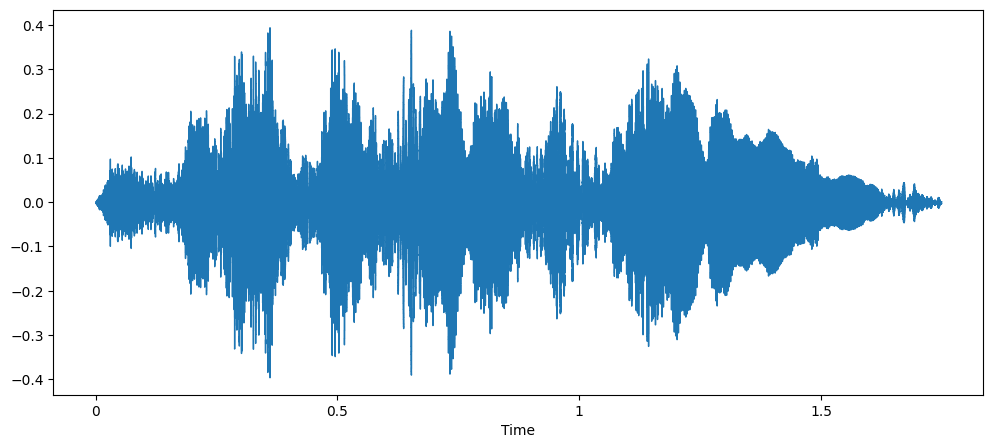

In [64]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
# Save the figure
plt.savefig("StretchedAudio.png")
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

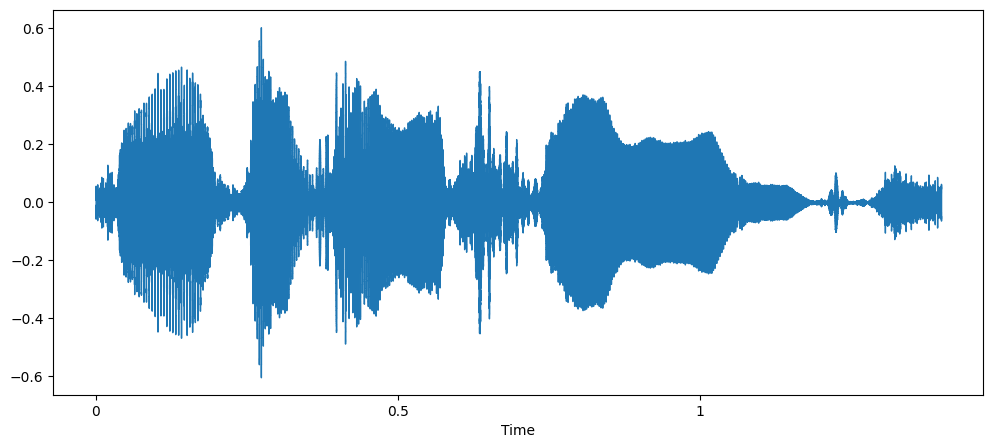

In [65]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
# Save the figure
plt.savefig("ShiftedAudio.png")
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

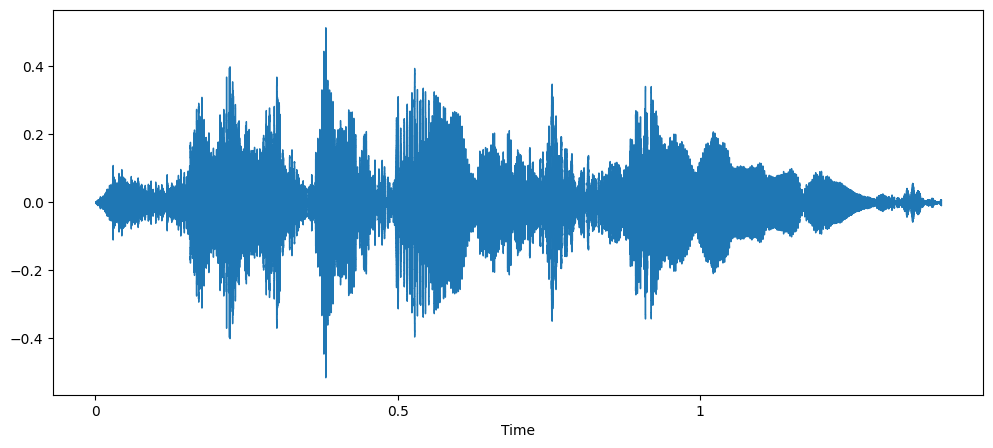

In [66]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
# Save the figure
plt.savefig("PitchedAudio.png")
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [74]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [75]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


In [76]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(Tess_df.Path,Tess_df.Emotions,range(Tess_df.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)         

2it [00:00,  6.34it/s]

0 audio has been processed


501it [01:22,  4.34it/s]

500 audio has been processed


1001it [03:03,  5.08it/s]

1000 audio has been processed


1501it [04:59,  4.00it/s]

1500 audio has been processed


2001it [06:44,  5.17it/s]

2000 audio has been processed


2501it [08:24,  3.66it/s]

2500 audio has been processed


2800it [09:24,  4.96it/s]

Done
Time:  564.6829967129997


In [78]:
len(X), len(Y), Tess_df.Path.shape


(11200, 11200, (2800,))

In [79]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2257,2258,2259,2260,2261,2262,2263,2264,2265,Emotions
0,0.028809,0.051758,0.071777,0.066895,0.075684,0.078613,0.073730,0.083496,0.071289,0.062012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
1,0.034668,0.061035,0.081543,0.090332,0.097168,0.101074,0.098145,0.099121,0.092773,0.098145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
2,0.031250,0.047852,0.078125,0.079102,0.087402,0.088379,0.076172,0.073242,0.061523,0.054688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
3,0.030273,0.046875,0.078125,0.079102,0.091309,0.094238,0.082031,0.080078,0.067383,0.057617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
4,0.020508,0.027344,0.038086,0.036133,0.035645,0.046387,0.061035,0.084473,0.104004,0.116699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear


In [80]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2257,2258,2259,2260,2261,2262,2263,2264,2265,Emotions
0,0.028809,0.051758,0.071777,0.066895,0.075684,0.078613,0.073730,0.083496,0.071289,0.062012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
1,0.034668,0.061035,0.081543,0.090332,0.097168,0.101074,0.098145,0.099121,0.092773,0.098145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
2,0.031250,0.047852,0.078125,0.079102,0.087402,0.088379,0.076172,0.073242,0.061523,0.054688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
3,0.030273,0.046875,0.078125,0.079102,0.091309,0.094238,0.082031,0.080078,0.067383,0.057617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
4,0.020508,0.027344,0.038086,0.036133,0.035645,0.046387,0.061035,0.084473,0.104004,0.116699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear


In [81]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2262         True
2263         True
2264         True
2265         True
Emotions    False
Length: 2267, dtype: bool


In [82]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2262        False
2263        False
2264        False
2265        False
Emotions    False
Length: 2267, dtype: bool


(11200, 2267)

In [83]:
np.sum(Emotions.isna())


0           0
1           0
2           0
3           0
4           0
           ..
2262        0
2263        0
2264        0
2265        0
Emotions    0
Length: 2267, dtype: int64

In [120]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [121]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [122]:
Y.shape

(11200, 7)

In [123]:
X.shape


(11200, 2266)

In [138]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8960, 2266), (8960, 7), (2240, 2266), (2240, 7))

In [140]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [141]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8960, 2266), (8960, 7), (2240, 2266), (2240, 7))

In [143]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [145]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)

In [153]:
# Define EarlyStopping callback with mode='max' to monitor validation accuracy
early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=10, verbose=1, restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [147]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((8960, 2266, 1), (8960, 7), (2240, 2266, 1), (2240, 7))

In [151]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 2266, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2266, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1133, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1133, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1133, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 567, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 567, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 567, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 567, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 284, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 284, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 284, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 142, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 142, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 142, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 142, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 71, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 71, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9088)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     4,653,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         3,59

 Total params: 6,931,079 (26.44 MB)

 Trainable params: 6,926,727 (26.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [154]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 217ms/step - accuracy: 0.9636 - loss: 0.1100 - val_accuracy: 0.3772 - val_loss: 4.1982 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - accuracy: 0.9863 - loss: 0.0416 - val_accuracy: 0.5768 - val_loss: 1.5623 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 218ms/step - accuracy: 0.9908 - loss: 0.0280 - val_accuracy: 0.9165 - val_loss: 0.2299 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.9939 - loss: 0.0184 - val_accuracy: 0.9254 - val_loss: 0.2529 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step - accuracy: 0.9956 - loss: 0.0136 - val_accuracy: 0.9951 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - accuracy: 0.9951 - loss: 0.0148 - val_accuracy: 0.9674 - val_loss: 0.0883 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - accuracy: 0.9

 7/70 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 4.0431e-04

W0000 00:00:1713727995.889946    1040 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9992 - loss: 0.0016
Accuracy of our model on test data :  99.91071224212646 %


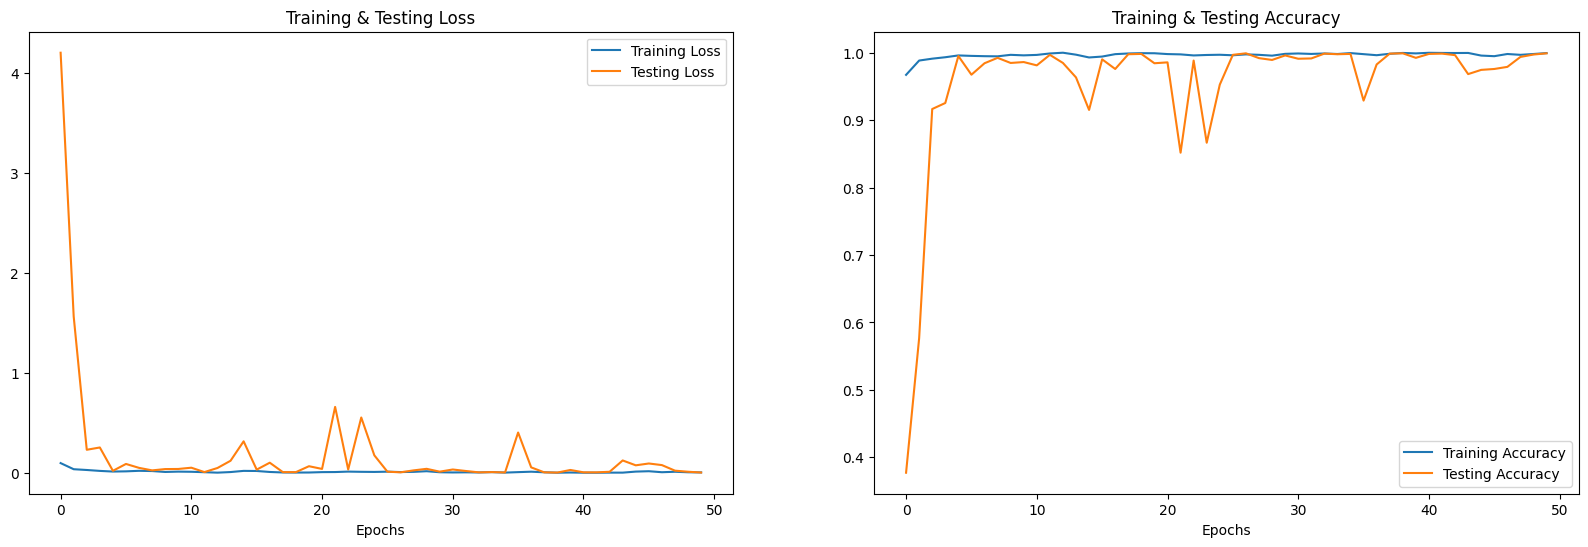

<Figure size 640x480 with 0 Axes>

In [155]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
# Save the figure
plt.savefig("Training_Testing_loss.png")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()
# Save the figure
plt.savefig("Training_Testing_Accuracy.png")

In [156]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

 5/70 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step

W0000 00:00:1713728041.012997    1039 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


,Predicted Labels,Actual Labels
0,neutral,neutral
1,disgust,disgust
2,neutral,neutral
3,disgust,disgust
4,happy,happy
5,surprise,surprise
6,angry,angry
7,happy,happy
8,disgust,disgust
9,neutral,neutral


In [157]:
df0


,Predicted Labels,Actual Labels
0,neutral,neutral
1,disgust,disgust
2,neutral,neutral
3,disgust,disgust
4,happy,happy
...,...,...
2235,disgust,disgust
2236,happy,happy
2237,surprise,surprise
2238,fear,fear


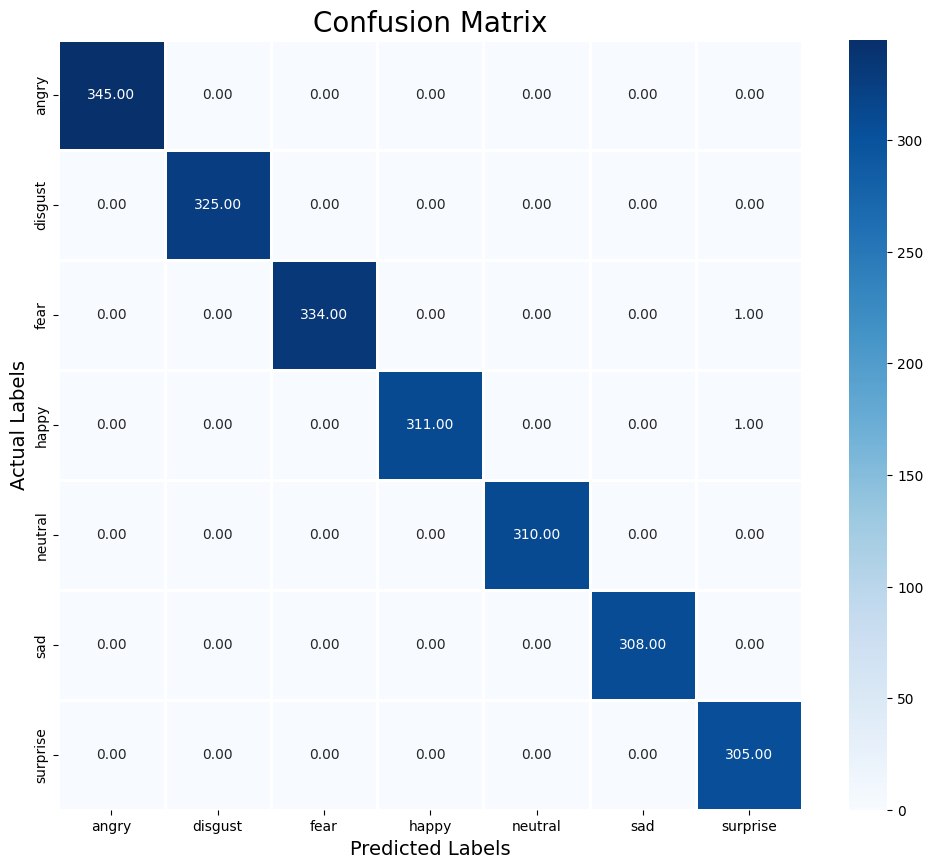

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       345
     disgust       1.00      1.00      1.00       325
        fear       1.00      1.00      1.00       335
       happy       1.00      1.00      1.00       312
     neutral       1.00      1.00      1.00       310
         sad       1.00      1.00      1.00       308
    surprise       0.99      1.00      1.00       305

    accuracy                           1.00      2240
   macro avg       1.00      1.00      1.00      2240
weighted avg       1.00      1.00      1.00      2240



<Figure size 640x480 with 0 Axes>

In [158]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
# Save the figure
plt.savefig("ConsfusionMatrix.png")
print(classification_report(y_test0, y_pred0))

In [162]:
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [165]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.keras")
print("Loaded model from disk")

Loaded model from disk


In [166]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

 3/70 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 1.0000 - loss: 7.5194e-05

W0000 00:00:1713728287.360665    1040 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9994 - loss: 0.0036
compile_metrics: 99.91%
